# Standard segmentation/measurement
Typical steps are import, project (sum or max or combo), backsub.
Then blur, thresfrac (max, percentile, avg), filter objects (area/circ), dilate (border)
Then measure subtracted and shapes and output table.

In [1]:
# This notebook follows a standard segmentation workflow
import numpy as np
import tifffile
import napari
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

In [2]:
#first load the images, here we have individually saved channels
fnames=['003003-1-001001001.tif','003003-1-001001002.tif','003003-1-001001003.tif']
img=np.array([tifffile.imread(fnames[i]) for i in range(len(fnames))])

In [3]:
viewer=napari.view_image(img,channel_axis=0)

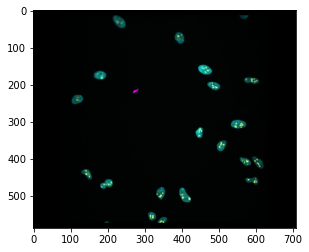

In [4]:
snap=viewer.screenshot()
plt.imshow(snap)

In [5]:
def findBackground(timg,smstd,ballrad,border,measrad):
    #now find the background of a multichannel image
    #finds the mininum of a boxcar filter over the image excluding the border
    #start by gaussian filtering
    #note if there is a transmitted light channel it should be removed first
    img=timg
    if(img.ndim<3):
        img=np.array([timg])
    nch=img.shape[0]
    smoothed=[ndi.gaussian_filter(img[i],sigma=smstd,mode='reflect') for i in range(nch)]
    mins=[smoothed[i].min() for i in range(nch)]
    print('sm chan mins: '+str(mins))
    summed=smoothed[0]-mins[0]
    for i in range(1,nch):
        summed+=smoothed[i]-mins[i]
    minfilt=ndi.uniform_filter(summed,size=2*ballrad,mode='reflect')
    minpos=np.argmin(minfilt[border:-border,border:-border])
    print('flat min index:'+str(minpos))
    width2=img.shape[2]-2*border
    miny=int(minpos/width2)
    minx=minpos-miny*width2
    miny=miny+border
    minx=minx+border
    #now measure the background in all the channels
    backlab=np.zeros(img.shape[1:],dtype=float)
    def getCircMask(xc,yc,rad,width,height):
        xs,ys=np.meshgrid(np.arange(width),np.arange(height))
        return ((xs-minx)**2+(ys-miny)**2)<=(rad**2)
        
    backlab=getCircMask(minx,miny,measrad,img.shape[2],img.shape[1])
    backavg=[img[i][backlab].mean() for i in range(nch)]
    return minx,miny,backavg,minfilt,summed

In [6]:
minx,miny,backavg,_,_=findBackground(img,3,40,200,30)
print('background pos:'+str([minx,miny]))
print('background measurements:'+str(backavg))

sm chan mins: [95, 94, 112]
flat min index:153000
background pos:[200, 425]
background measurements:[144.96207018787663, 126.56504785537044, 151.5654023395959]


In [7]:
viewer.add_points([[miny,minx]],size=60)

<Points layer 'Points' at 0x2188b470b88>

In [8]:
backsub=[img[i]-backavg[i] for i in range(len(img))]

In [9]:
def findNuclei(nucimg,smstd,threshfrac,threshstat='Max',threshpercentile=99.0,minarea=10,maxarea=1e+6):
    #takes a nuclear image and thresholds it (fraction of max, percentile, and avg)
    stats=['Max','Percentile','Avg']
    statfuncs=[np.max,np.percentile,np.mean]
    statidx=stats.index(threshstat)
    smoothed=ndi.gaussian_filter(nucimg,sigma=smstd,mode='reflect')
    if(statidx==0):
        statval=smoothed.max()
    if(statidx==1):
        statval=np.percentile(smoothed,threshpercentile)
    if(statidx==2):
        statval=smoothed.mean()
    threshval=threshfrac*statval
    #find the objects
    objects,nobj=ndi.label(smoothed>threshval)
    #filter out the ones that are too big or too small
    areas=ndi.sum(np.ones(objects,shape),objects,range(1,nobj))
    filtered=np.where((areas<minarea) | (areas>maxarea))[0]+1
    for idx in filtered:
        objects[objects==idx]=0.0
    #refind the objects
    objects,nobj=ndi.label(objects>0.0)
    return objects